## **4. Document Clustering** (K-means)  

In [48]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from pandas import *
import numpy as np
import matplotlib.pyplot as plt

import os, shutil, re
from pathlib import Path
from os import path

Lire les candidats termes extraits à l'étape de prétraitement

In [49]:
base_path = '../04-filtrage/output/'
acteur = 'inesss'
tag = ''

if tag:
    csv_file = acteur + '_' + tag + '_significant-collocations.csv'

else:
    csv_file = acteur + '_significant-collocations.csv'

In [50]:
with open(base_path+csv_file, encoding='utf-8') as f:
    csv = read_csv(f)[["Terme"]]#, "Structure syntaxique", "Fréquence"]] # "LLR", "p-value"]]

csv

,Terme
0,traitement
1,évaluation
2,jamp
3,médicaments
4,inesss
...,...
17620,stabilisation des lits aux soins
17621,dario
17622,stabilisation des lits réguliers occupés
17623,stabilisation des lits réguliers


In [51]:
vocabulaire = [str(t).lower() for t in list(csv['Terme'])]

Quand on lis le corpus, ajouter : 
- Lire le CSV du crawling contenant les URLs avec l'élément title pour join les documents avec leur titre (et essayer d'appliquer drop_duplicates() pour voir)

In [52]:
base_path = '../03-corpus/2-data/1-fr/'
if tag:
    base_path = path.join(base_path, acteur, acteur + '_' + tag + '.csv')

else:
    base_path = path.join(base_path, acteur +  '.csv')
        
with open(base_path, "r", encoding = "UTF-8") as f:
    data = read_csv(base_path, sep=',')
    text = data['text'].drop_duplicates().dropna().tolist()

nb_docs = len(text)

In [53]:
corpus = [str(t).strip('\n').lower().replace('’', '\'') for t in text]
    
punct = '[!#$%&•►*+,;<=>?@[\]^_{|}~©«»—“”–—]'
spaces = '\s+'
postals = '([a-zA-Z]+\d+|\d+[a-zA-Z]+)+'
phones = '\d{3}\s\d{3}-\d{4}' #très simple (trop)

corpus = [str(t).strip('\n').lower().replace('’', '\'') for t in corpus]
corpus = [re.sub(spaces, ' ', t) for t in corpus]
corpus = [re.sub(punct, ' ', t).replace("' ", "'" ).replace("'", "'") for t in corpus]
corpus = [re.sub(phones, ' STOP ', t) for t in corpus]
corpus = [re.sub(postals, ' STOP ', t) for t in corpus]
corpus = [t.replace("  ", " " ) for t in corpus]

### K-means avec *sklearn*

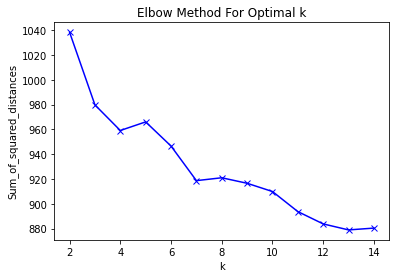

Number of clusters used (K) = 3
                                               Document  cluster
1189  MediSure Empower (mesure de la glycémie) Dénom...        0
818   Opdivo (oncologie) Dénomination commune // Suj...        0
819   Sprycel (oncologie) Dénomination commune // Su...        0
820   Yervoy (oncologie) Dénomination commune // Suj...        0
821   Sprycel (leucémie lymphoblastique aigüe) Dénom...        0
...                                                 ...      ...
523   Risques d’hospitalisation et projections des b...        2
525   Risques d’hospitalisation et projections des b...        2
526   Risques d’hospitalisation et projections des b...        2
518   Risques d’hospitalisation et projections des b...        2
313   Risques d’hospitalisation et projections des b...        2

[1190 rows x 2 columns]


In [54]:
K = range(2,15)
Sum_of_squared_distances = []
silhouette_scores = []

for k in K:
    vectorizer = TfidfVectorizer(vocabulary = set(vocabulaire),ngram_range=(1,12), lowercase=False)
    X = vectorizer.fit_transform(corpus)
    #true_k = int(input())
    model = KMeans(n_clusters=k, init='k-means++', max_iter=200, n_init=1)
    model.fit(X)
    Sum_of_squared_distances.append(model.inertia_)

    # Run LSA
    # Since LSA/SVD results are not normalized,
    # we redo the normalization to improve the k-means result.
    svd = TruncatedSVD(n_components=k)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)

    X = lsa.fit_transform(X)
    model.fit(X)

    labels=model.labels_
    clusters= DataFrame(list(zip(text,labels)),columns=['Document','cluster'])
    #print(clusters.sort_values(by=['cluster']))

    original_space_centroids = svd.inverse_transform(X)
    order_centroids = original_space_centroids.argsort()[:, ::-1]
    silhouette_scores.append([k, metrics.silhouette_score(X, labels)])

df = DataFrame(silhouette_scores, columns=['Nombre de clusters (k)', 'Score Silhouette'])
true_k = int(df[df['Score Silhouette'] == df['Score Silhouette'].max()]['Nombre de clusters (k)'])
df

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

print('Number of clusters used (K) = ' + str(true_k))
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=1)

# Run LSA
# Since LSA/SVD results are not normalized,
# we redo the normalization to improve the k-means result.
svd = TruncatedSVD(n_components=true_k)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

X = lsa.fit_transform(X)
model.fit(X)

labels=model.labels_
clusters= DataFrame(list(zip(text,labels)),columns=['Document','cluster'])
print(clusters.sort_values(by=['cluster']))

# print("Top terms per cluster:")
# original_space_centroids = svd.inverse_transform(X)
# order_centroids = original_space_centroids.argsort()[:, ::-1]

# terms = vectorizer.get_feature_names_out()
# for i in range(true_k):
#     #clusters[clusters['cluster'] == i])
#     print("Cluster %d:" % i, end="")
#     for ind in order_centroids[i, :10]:
#         print(" %s" % terms[ind], end="")

clusters.to_csv('../06-clustering/' + acteur + '_clusters-K-means.csv')

#### Topic modeling sur nos clusters (*sklearn LDA, LSA, NMF*)

In [55]:
cluster = 0
corpus = clusters[clusters['cluster'] == cluster]['Document'].tolist()

In [56]:
vectorizer = TfidfVectorizer(vocabulary = set(vocabulaire),ngram_range=(1,12), lowercase=False)
X = vectorizer.fit_transform(corpus)
tfidf_features_names = vectorizer.get_feature_names_out()

from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
no_topics = 15

# Run NMF
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(X)

# # Run LDA
# lda = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)

# Run LSA
lsa = TruncatedSVD(n_components=no_topics, algorithm='randomized', n_iter=100, random_state=122).fit(X)

c:\Users\p1115145\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\decomposition\_nmf.py:1477: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(


In [57]:
def display_topics(model, feature_names, no_top_words):
    tab = []
    for topic_idx, topic in enumerate(model.components_):
        #print("Topic %d:" % (topic_idx))
        tab.append(" - ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
    
    #tab = [" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]) for topic in enumerate(model.components_)]
    df = DataFrame(tab, columns=['Topic']) # Éventuellement on voudrait remplacer l'index par un label plus significatif
    
    base_path = '../06-clustering/' + acteur + '/'
    if tag:
        output_file = acteur + '_' + tag + '_cluster_' + str(cluster) + '_' + (str(model).split('(')[0]) +'.csv'
    else:
        output_file = acteur + '_cluster_' + str(cluster) + '_' + (str(model).split('(')[0]) +'.csv'
    df.to_csv(base_path + output_file)
    return df


no_top_words = 50

In [58]:
print("Topic Modeling avec LSA")
display_topics(lsa, tfidf_features_names, no_top_words)

Topic Modeling avec LSA


,Topic
0,ministre - sodium - médicaments - listes des m...
1,glycémie - glucose - glucose dans le sang - sa...
2,traitement - coût - efficacité - patients - as...
3,indication reconnue - indication - type - indi...
4,type - diabète type - diabète - metformine - r...
5,lymphome - nivolumab - védotine - mélanome - b...
6,plaques - indications - type - sclérose - sclé...
7,listes des médicaments - listes - inscription ...
8,recommandation - extrait - amyotrophie - amyot...
9,mcg - fluticasone - xinafoate - propionate - s...


#### Topic modeling avec nos clusters (*Hugging face sentence transformers*)

In [59]:
path = '../05-transformation/'
acteur = 'msss'
tag = 'dependances'

if tag:
    csv_file = acteur + '_' + tag + '_weighting_OKapiBM25.csv'

else:
    csv_file = acteur + '_weighting_OKapiBM25.csv'

In [60]:
with open(path + csv_file, encoding='utf-8') as f:
    df = DataFrame(read_csv(f)['Terme'])
    df.columns = ['Keyword']



n_terms = len(df)
df

,Keyword
0,indicateurs de gestion utilisés par le ministè...
1,concours pour le prix du conseil de la fédération
2,attestation temporaire de conformité en dépend...
3,délivrance d'une attestation temporaire de con...
4,changements apportés au puds par santé canada
...,...
1239,thérapie
1240,centre
1241,centre d'hébergement
1242,hommes


In [61]:
cluster_accuracy = 75  # 0-100 (100 = very tight clusters, but higher percentage of no_cluster groups)
min_cluster_size = 10  # set the minimum size of cluster groups. (Lower number = tighter groups)

from sentence_transformers import SentenceTransformer, util
transformer = 'all-MiniLM-L6-v2'  # provides the best quality'

In [62]:
# store the data
cluster_name_list = []
corpus_sentences_list = []
df_all = []

corpus_set = set(df['Keyword'])
corpus_set_all = corpus_set
cluster = True

In [63]:
# keep looping through until no more clusters are created

cluster_accuracy = cluster_accuracy / 100
model = SentenceTransformer(transformer)

while cluster:

    corpus_sentences = list(corpus_set)
    check_len = len(corpus_sentences)

    corpus_embeddings = model.encode(corpus_sentences, batch_size=256, show_progress_bar=True, convert_to_tensor=True)
    clusters = util.community_detection(corpus_embeddings, min_community_size=min_cluster_size, threshold=cluster_accuracy, init_max_size=len(corpus_embeddings))

    for keyword, cluster in enumerate(clusters):
        print("\nCluster {}, #{} Elements ".format(keyword + 1, len(cluster)))

        for sentence_id in cluster[0:]:
            print("\t", corpus_sentences[sentence_id])
            corpus_sentences_list.append(corpus_sentences[sentence_id])
            cluster_name_list.append("Cluster {}, #{} Elements ".format(keyword + 1, len(cluster)))

    df_new = DataFrame(None)
    df_new['Cluster Name'] = cluster_name_list
    df_new["Keyword"] = corpus_sentences_list

    df_all.append(df_new)
    have = set(df_new["Keyword"])

    corpus_set = corpus_set_all - have
    remaining = len(corpus_set)
    print("Total Unclustered Keywords: ", remaining)
    if check_len == remaining:
        break

c:\Users\p1115145\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:560: FutureWarning: `cached_download` is the legacy way to download files from the HF hub, please consider upgrading to `hf_hub_download`
  warnings.warn(
Batches: 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]



Cluster 1, #32 Elements 
	 services de santé
	 réseau de la santé et des services
	 santé et services
	 partenaires du réseau de la santé et des services
	 établissements du réseau de la santé et des services
	 ministère de la santé et des services
	 accès aux services de santé
	 réseau de la santé et des services sociaux
	 gestion en santé et services
	 partenaires du réseau de la santé et des services sociaux
	 vertu de la loi sur les services de santé
	 établissements du réseau de la santé et des services sociaux
	 ministre de la santé et des services
	 santé et services sociaux
	 centre intégré de santé et de services sociaux
	 stratégie d'accès aux services de santé
	 ministère de la santé et des services sociaux
	 centre de santé
	 indicateurs de gestion en santé et services
	 gestion en santé et services sociaux
	 problèmes de santé
	 responsabilité de santé
	 ministre de la santé et des services sociaux
	 centres intégrés de santé et de services sociaux
	 ministère de la santé

Batches: 100%|██████████| 5/5 [00:03<00:00,  1.66it/s]



Cluster 1, #10 Elements 
	 services sociaux ententes
	 services sociaux
	 services sociaux ententes de gestion
	 services sociaux concernés
	 services sociaux (ciusss)
	 services sociaux rassemble
	 services sociaux (cisss)
	 services sociaux pour les personnes en situation
	 services entièrement
	 services sociaux (msss)
Total Unclustered Keywords:  1134


Batches: 100%|██████████| 5/5 [00:02<00:00,  1.70it/s]

Total Unclustered Keywords:  1134


In [64]:
# make a new dataframe from the list of dataframe and merge back into the orginal df
df_new = concat(df_all)
df = df.merge(df_new.drop_duplicates("Keyword"), how='left', on="Keyword")

In [65]:
# rename the clusters to the shortest keyword in the cluster
# Est-ce qu'on pourrait plutôt le renommer par le keyword le plus fréquent ?

df['Length'] = df['Keyword'].astype(str).map(len)
df = df.sort_values(by="Length", ascending=True)

df['Cluster Name'] = df.groupby('Cluster Name')['Keyword'].transform('first')
df.sort_values(['Cluster Name', "Keyword"], ascending=[True, True], inplace=True)

df['Cluster Name'] = df['Cluster Name'].fillna("zzz_no_cluster")

del df['Length']

In [66]:
# move the cluster and keyword columns to the front
col = df.pop("Keyword")
df.insert(0, col.name, col)

col = df.pop('Cluster Name')
df.insert(0, col.name, col)

df.sort_values(["Cluster Name", "Keyword"], ascending=[True, True], inplace=True)

In [67]:
uncluster_percent = (remaining / n_terms) * 100
clustered_percent = 100 - uncluster_percent
print(clustered_percent,"% of rows clustered successfully!")

8.842443729903536 % of rows clustered successfully!


In [68]:
if tag:
    file_output = acteur + '_' + tag + '_topics_sentence-transformers.csv'
else: 
    file_output = acteur + '_clusters_topics_sentence-transformers.csv'
df.to_csv('../06-clustering/' + file_output , index=False)

#### *NLTK* (à suivre)

Regarder le fil de discussion ici pour voir comment avoir un dataframe avec les documents et leur cluster assigné
https://stackoverflow.com/questions/59538701/how-do-i-obtain-individual-centroids-of-k-mean-cluster-using-nltk-python 


In [69]:
import nltk
from nltk.cluster import EMClusterer, KMeansClusterer

vectorizer = TfidfVectorizer(vocabulary = set(vocabulaire),ngram_range=(1,10), lowercase=False)
X = vectorizer.fit_transform(corpus).toarray()

km = KMeansClusterer(6, distance = nltk.cluster.util.cosine_distance) 

clusters = km.cluster(X,assign_clusters = True)
clusters

centroids = km._centroid
centroids

c:\Users\p1115145\AppData\Local\Programs\Python\Python310\lib\site-packages\nltk\cluster\util.py:130: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (numpy.dot(u, v) / (sqrt(numpy.dot(u, u)) * sqrt(numpy.dot(v, v))))


<bound method KMeansClusterer._centroid of <KMeansClusterer means=[array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.])] repeats=1>>

In [70]:
clusters = km.cluster_vectorspace(X, trace=False)
clusters